
# Digital Marketing Campaign Performance Analysis

## Context and Objective

This analysis examines social media campaign data from XYZ company run on Facebook.
**Ideally, we should have revenue return data to calculate the actual ROI of each campaign.**
However, since we don't have this information, we'll treat this problem as a **cost optimization exercise**.

Our objectives are:
- Identify and cut campaigns with relatively high spending and low performance
- Discover demographic and segmentation patterns that work
- Recommend adjustments to maximize investment efficiency

## About the Data

The file `KAG_conversion_data.csv` <a href="https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking/data" target="_blank">kaggle</a>
contains 1,143 observations distributed across 11 variables:

1. **ad_id**: Unique identifier for each ad
2. **xyz_campaign_id**: XYZ company campaign ID
3. **fb_campaign_id**: Facebook campaign tracking ID
4. **age**: Target audience age range
5. **gender**: Target audience gender (male/female)
6. **interest**: Interest category code (according to Facebook public profile)
7. **Impressions**: Number of times the ad was displayed
8. **Clicks**: Number of clicks received by the ad
9. **Spent**: Amount invested by XYZ company to display the ad
10. **Total_Conversion**: Total number of people who showed interest in the product after seeing the ad
11. **Approved_Conversion**: Total number of people who actually purchased the product

In [34]:
# Loading necessary libraries
library(readr)
library(tidyverse)
library(ggplot2)
library(skimr)
library(DataExplorer)
library(gridExtra)
library(scales)

In [35]:
# Function to create conversion funnel charts
# Source: https://gist.github.com/jjesusfilho/fd14b58becab4924befef5be239c6011

gg_funnel <- function(x, text = NULL, color = NULL, lbl_size = 4){
  
  #### Type validation ####
  if (!is.numeric(x)){
    stop("x must be a numeric vector")
  }
  
  if (any(x < 0)){
    stop("This function does not accept negative values")
  }
  
  x <- sort(x, decreasing = TRUE)
  
  if (is.null(color)){
    color <- colorspace::qualitative_hcl(length(x), palette = "Dark 3")
  }
  
  if (is.null(text)){
    text <- as.character(x)
  }
  
  if(!all.equal(length(x), length(text), length(color))){
    stop("x, text, and color must have the same length")
  }
  
  #### Create x coordinates ####
  l1 <- vector("list", length(x))
  
  for (i in 1:length(x)){
    if (i == 1){
      x3 <- x[1]
      x4 <- 0
      x1 <- seq(x4, x3, length.out = 6)[2]
      x2 <- seq(x4, x3, length.out = 6)[5]
    } else {
      x4 <- l1[[i-1]][1]
      x3 <- l1[[i-1]][2]
      x1 <- seq(x4, x3, length.out = 6)[2]
      x2 <- seq(x4, x3, length.out = 6)[5]
    }
    
    l1[[i]] <- c(x1, x2, x3, x4)
  }
  
  #### Create y coordinates ####
  l2 <- purrr::map(length(x):1, ~{
    c(.x*5-5, .x*5-5, .x*5, .x*5)
  })
  
  #### Create data.frame based on coordinates ####
  dfs <- purrr::map2(l1, l2, ~{
    data.frame(x = .x, y = .y)
  })
  
  ### Create individual plots and stack them
  p <- ggplot2::ggplot()
  
  for (i in 1:length(dfs)){
    p <- p +
      ggplot2::geom_polygon(data = dfs[[i]], ggplot2::aes(x = x, y = y), 
                            fill = color[i]) +
      ggplot2::annotate("text", label = text[i], x = x[1]/2,
                        y = mean(dfs[[i]]$y),
                        size = lbl_size,
                        fontface = "bold",
                        color = "black") +
      ggplot2::theme_minimal() +
      ggplot2::theme(
        axis.title = ggplot2::element_blank(),
        axis.text = ggplot2::element_blank(),
        axis.ticks = ggplot2::element_blank(),
        panel.grid = ggplot2::element_blank()
      )
  }
  
  p
}

In [36]:
# Loading data
df <- read_csv("data/KAG_conversion_data.csv")

Rows: 1143 Columns: 11


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): age, gender
dbl (9): ad_id, xyz_campaign_id, fb_campaign_id, interest, Impressions, Clic...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
# Data structure overview
glimpse(df)

Rows: 1,143
Columns: 11
$ ad_id               <dbl> 708746, 708749, 708771, 708815, 708818, 708820, 70…
$ xyz_campaign_id     <dbl> 916, 916, 916, 916, 916, 916, 916, 916, 916, 916, …
$ fb_campaign_id      <dbl> 103916, 103917, 103920, 103928, 103928, 103929, 10…
$ age                 <chr> "30-34", "30-34", "30-34", "30-34", "30-34", "30-3…
$ gender              <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", "M", …
$ interest            <dbl> 15, 16, 20, 28, 28, 29, 15, 16, 27, 28, 31, 7, 16,…
$ Impressions         <dbl> 7350, 17861, 693, 4259, 4133, 1915, 15615, 10951, …
$ Clicks              <dbl> 1, 2, 0, 1, 1, 0, 3, 1, 1, 3, 0, 0, 0, 0, 7, 0, 1,…
$ Spent               <dbl> 1.43, 1.82, 0.00, 1.25, 1.29, 0.00, 4.77, 1.27, 1.…
$ Total_Conversion    <dbl> 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ Approved_Conversion <dbl> 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,…


In [38]:
# First rows of the dataset
head(df)

ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
708746,916,103916,30-34,M,15,7350,1,1.43,2,1
708749,916,103917,30-34,M,16,17861,2,1.82,2,0
708771,916,103920,30-34,M,20,693,0,0.00,1,0
708815,916,103928,30-34,M,28,4259,1,1.25,1,0
708818,916,103928,30-34,M,28,4133,1,1.29,1,1
708820,916,103929,30-34,M,29,1915,0,0.00,1,1


In [39]:
# Complete statistical summary
df %>% skimr::skim() %>% print()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             1143      
Number of columns          11        
_______________________              
Column type frequency:               
  character                2         
  numeric                  9         
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 age                   0             1   5   5     0        4          0
2 gender                0             1   1   1     0        2          0

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable       n_missing complete_rate       mean        sd     p0
1 ad_id                       0             1 987261.    193993.   708746
2 xyz_campaign_id             0             1

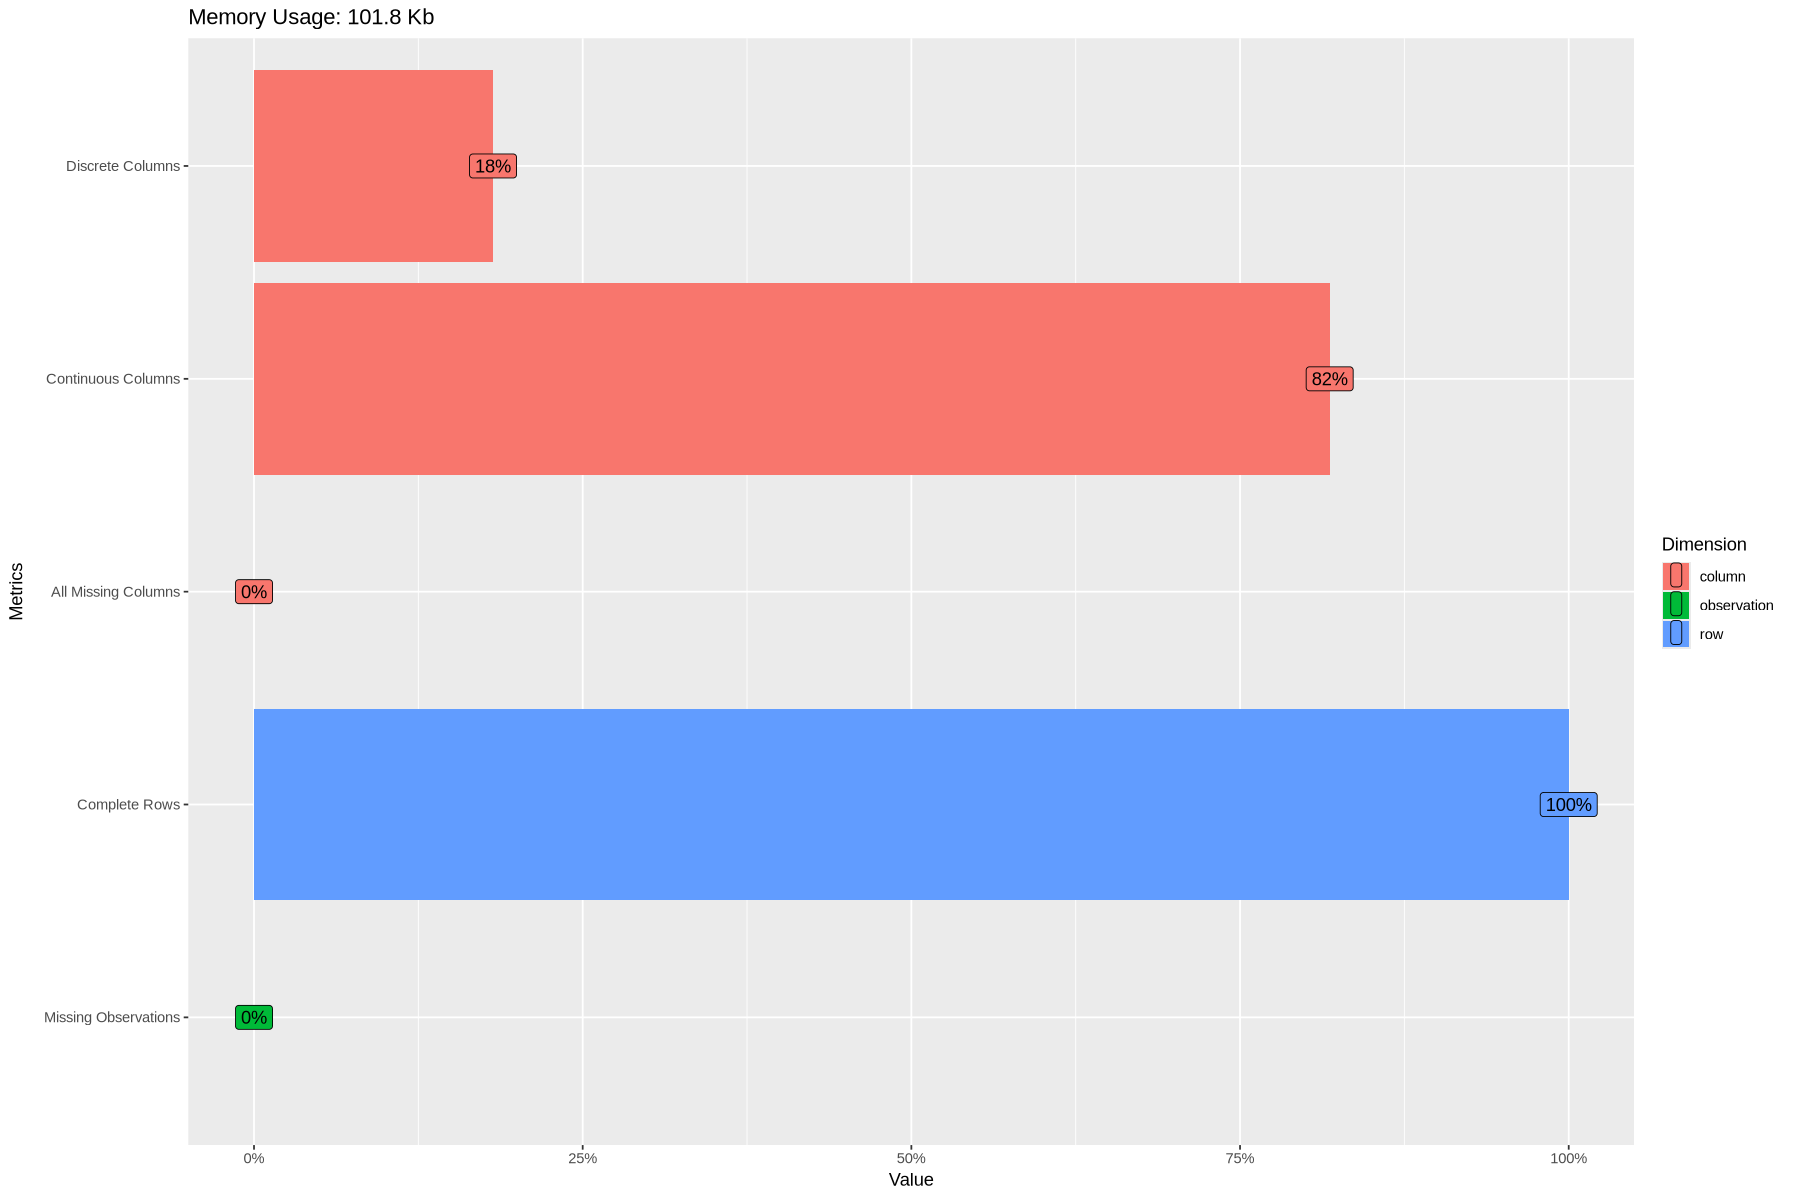

In [40]:
# Introductory visualization of data quality
plot_intro(df)

In [41]:
# Distribution of ads by campaign
df %>%
  group_by(xyz_campaign_id) %>%
  summarise(total = n())

xyz_campaign_id,total
<dbl>,<int>
916,54
936,464
1178,625


## Exploratory Analysis: Distribution by Campaign

We observe that **Campaign 916** had a much lower volume of ads compared 
to the others, while **Campaign 1178** was the most intensively worked.

Let's investigate how age groups are distributed in the database and how 
they behave in each campaign.

In [42]:
# General distribution by age range
df %>%
  group_by(age) %>%
  summarise(total = n())

age,total
<chr>,<int>
30-34,426
35-39,248
40-44,210
45-49,259


## Age Concentration

Approximately **60% of the database** is concentrated in the **30-39 years** range. 
How are these groups distributed when we consider each campaign individually?

In [43]:
# Age distribution by campaign
df %>%
  group_by(xyz_campaign_id, age) %>%
  summarise(total = n(), .groups = "drop_last") %>%
  mutate(percentage = round(total * 100 / sum(total), 2))

xyz_campaign_id,age,total,percentage
<dbl>,<chr>,<int>,<dbl>
916,30-34,29,53.70
916,35-39,12,22.22
916,40-44,6,11.11
916,45-49,7,12.96
936,30-34,196,42.24
936,35-39,89,19.18
936,40-44,75,16.16
936,45-49,104,22.41
1178,30-34,201,32.16



## Age Segmentation Pattern

All campaigns focus predominantly on the **30-34 years** range, with the difference 
being less pronounced in Campaign 1178. 

Now let's analyze how genders are distributed when we consider 
campaign and age range simultaneously.

In [44]:
# General distribution by gender
df %>%
  group_by(gender) %>%
  summarise(total = n())

gender,total
<chr>,<int>
F,551
M,592



## Gender Balance

The distribution between genders is quite balanced, with a slight predominance 
of the female audience in the overall database.

In [45]:
# Gender distribution by campaign
df %>%
  group_by(xyz_campaign_id, gender) %>%
  summarise(total = n(), .groups = "drop_last") %>%
  mutate(percentage = round(total * 100 / sum(total), 2))

xyz_campaign_id,gender,total,percentage
<dbl>,<chr>,<int>,<dbl>
916,F,19,35.19
916,M,35,64.81
936,F,256,55.17
936,M,208,44.83
1178,F,276,44.16
1178,M,349,55.84



## Difference in Campaign 1178

Only **Campaign 1178** shows a higher overall percentage of men. 
What if we include age ranges in this analysis?

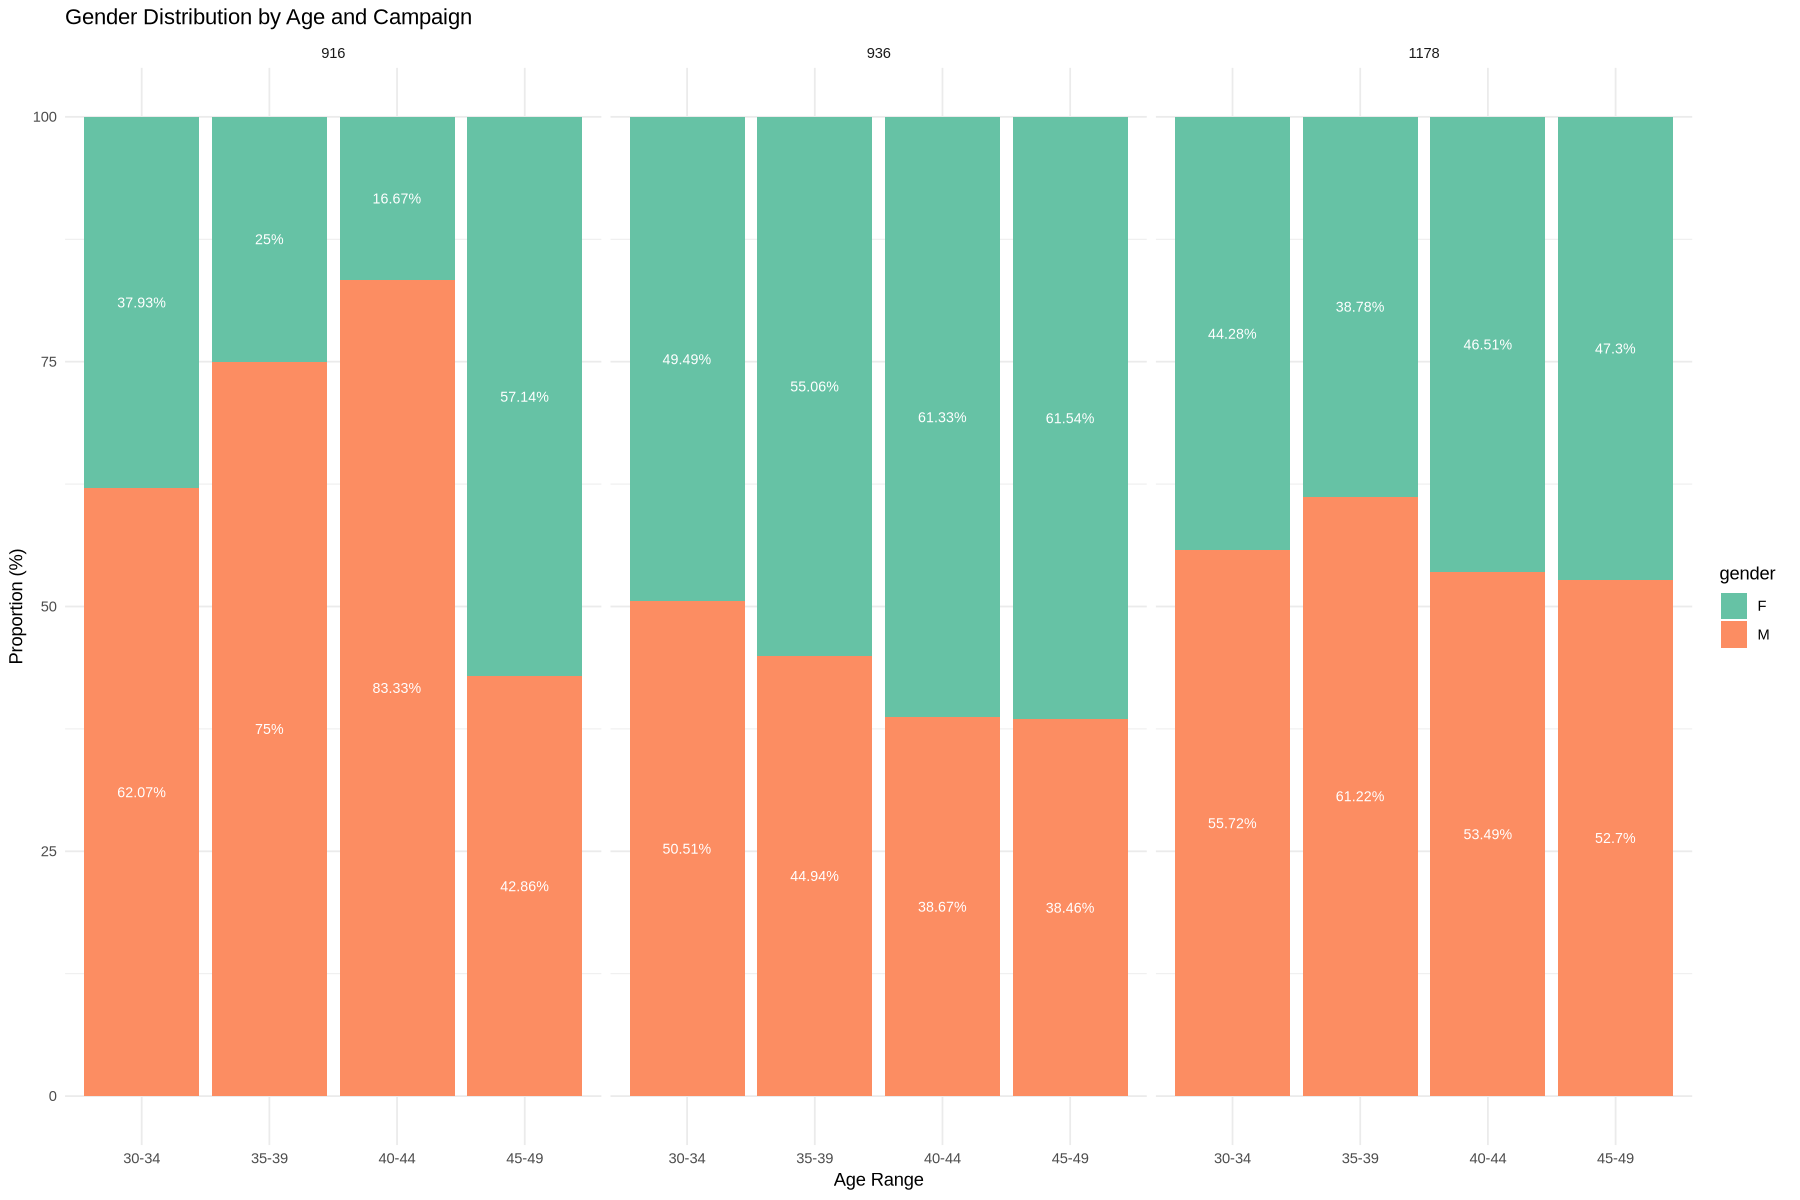

In [46]:
# Visualization: Gender distribution by age and campaign
df %>%
  group_by(xyz_campaign_id, age, gender) %>%
  summarise(total = n(), .groups = "drop_last") %>%
  mutate(percentage = round(total * 100 / sum(total), 2)) %>%
  ggplot(aes(x = age, y = percentage, fill = gender)) +
  geom_col() +
  geom_text(aes(label = paste0(percentage, "%")),
            position = position_stack(vjust = 0.5), size = 3, color = "white") +
  facet_wrap(~ xyz_campaign_id) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Gender Distribution by Age and Campaign",
    y = "Proportion (%)",
    x = "Age Range"
  ) +
  theme_minimal()


## Introduction of Performance Metrics

To deepen the analysis, let's calculate standard digital marketing metrics:

- **CTR (Click-Through Rate)**: Click rate relative to impressions
- **CPC (Cost Per Click)**: Average cost per click
- **CPA (Cost Per Acquisition)**: Cost per completed sale

In [47]:
# Performance metrics calculation
df <- df %>%
  mutate(
    CTR = ifelse(Impressions > 0, (Clicks / Impressions) * 100, NA),
    CPC = ifelse(Clicks > 0, Spent / Clicks, NA),
    CPA = ifelse(Approved_Conversion > 0, Spent / Approved_Conversion, NA)
  )

In [48]:
# Verification of new columns
head(df, 3)

ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CPC,CPA
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.01360544,1.43,1.43
708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.01119758,0.91,NA
708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.00000000,NA,NA


In [49]:
# Metrics aggregation by campaign
df_performance <- df %>%
  group_by(xyz_campaign_id) %>%
  summarise(
    ads_run = n_distinct(ad_id),
    investment = sum(Spent),
    impressions = sum(Impressions),
    clicks = sum(Clicks),
    leads = sum(Total_Conversion),
    sales = sum(Approved_Conversion),
    ctr_global = (clicks / impressions) * 100,
    cpc_global = investment / clicks,
    lead_to_sale_rate = (sales / leads) * 100,
    cpa_global = investment / sales,
    .groups = "drop"
  )

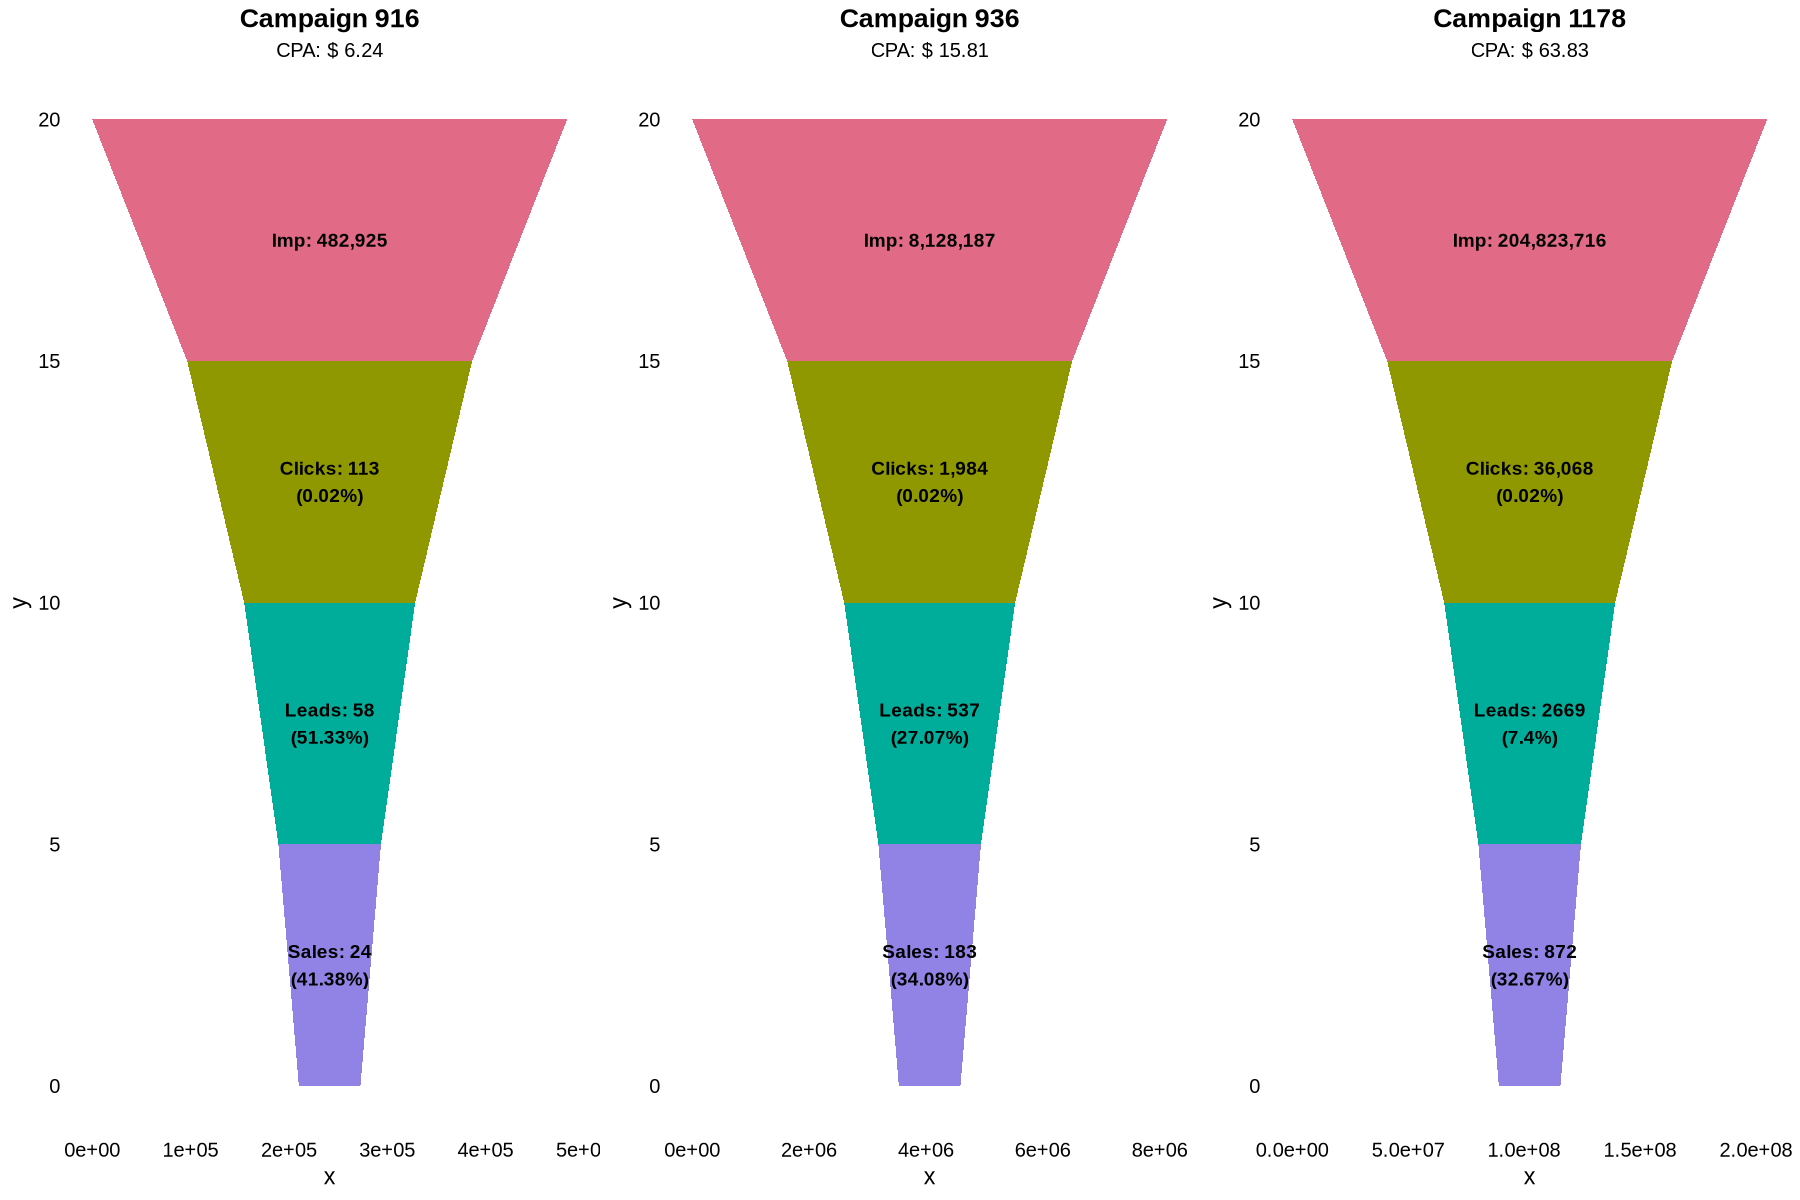

In [50]:
# Visualization: Conversion funnels by campaign
options(repr.plot.width = 15, repr.plot.height = 10)

plot_list <- list()

for(campaign in unique(df_performance$xyz_campaign_id)) {
  
  campaign_data <- df_performance %>%
    filter(xyz_campaign_id == campaign)
  
  funnel_vec <- c(
    campaign_data$impressions,
    campaign_data$clicks,
    campaign_data$leads,
    campaign_data$sales
  )
  
  texts <- c(
    paste0("Imp: ", scales::comma(funnel_vec[1])),
    paste0("Clicks: ", scales::comma(funnel_vec[2]), "\n(", 
           round(funnel_vec[2]/funnel_vec[1]*100, 2), "%)"),
    paste0("Leads: ", funnel_vec[3], "\n(", 
           round(funnel_vec[3]/funnel_vec[2]*100, 2), "%)"),
    paste0("Sales: ", funnel_vec[4], "\n(", 
           round(funnel_vec[4]/funnel_vec[3]*100, 2), "%)")
  )
  
  p <- gg_funnel(funnel_vec, text = texts) +
    labs(
      title = paste("Campaign", campaign), 
      subtitle = paste("CPA: $", round(campaign_data$cpa_global, 2))
    ) +
    theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5),
      axis.text = element_text(size = 12),
      axis.title = element_text(size = 14)
    )
  
  plot_list[[as.character(campaign)]] <- p
}

grid.arrange(grobs = plot_list, ncol = 3)

In [51]:
# Performance summary table
print(df_performance)

# A tibble: 3 × 11
  xyz_campaign_id ads_run investment impressions clicks leads sales ctr_global
            <dbl>   <int>      <dbl>       <dbl>  <dbl> <dbl> <dbl>      <dbl>
1             916      54       150.      482925    113    58    24     0.0234
2             936     464      2893.     8128187   1984   537   183     0.0244
3            1178     625     55662.   204823716  36068  2669   872     0.0176
# ℹ 3 more variables: cpc_global <dbl>, lead_to_sale_rate <dbl>,
#   cpa_global <dbl>


## Preliminary Performance Insights

**Campaign 916**: Shows low relative investment and few ads run, 
but has the **best lead→sale conversion rate** and consequently the **lowest CPA**. 
This may be the result of efficient segmentation, good niche choice (interest) 
or simply statistical luck.

**Campaign 1178**: Recorded relatively exorbitant spending and shows a **CPA 
at least 2x worse** than other campaigns, plus the worst lead→sale conversion rate.

### Questions to Investigate:
- Are the niches and segments of Campaign 916 included in 1178?
- In 1178, did some ads perform well but were "pulled down" by others?
- Are there specific patterns of interest and age that explain these differences?

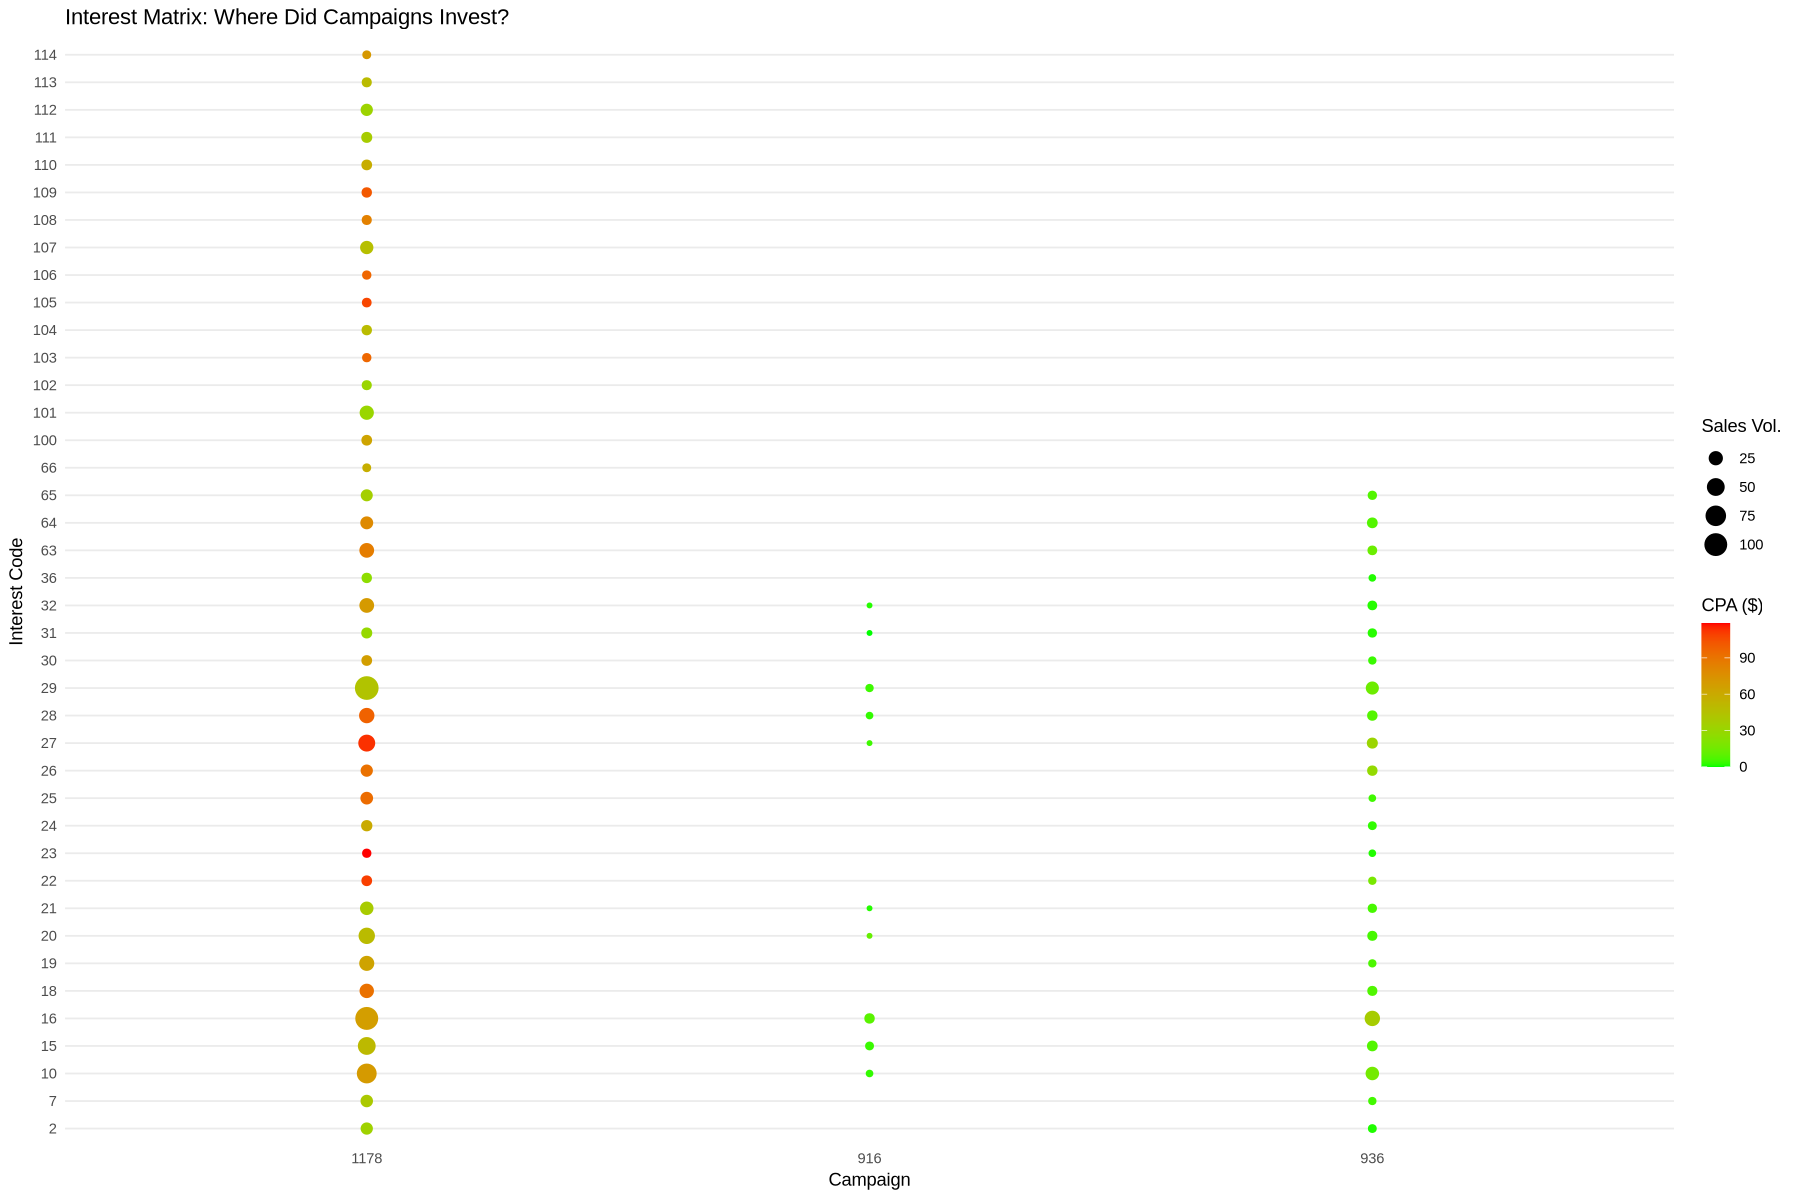

In [52]:

# Performance analysis by interest and campaign
interest_analysis <- df %>%
  mutate(xyz_campaign_id = as.character(xyz_campaign_id)) %>%
  group_by(interest, xyz_campaign_id) %>%
  summarise(
    sales = sum(Approved_Conversion),
    cpa = sum(Spent) / sum(Approved_Conversion),
    .groups = "drop"
  ) %>%
  filter(sales > 0)

# Visualization: Interest matrix
ggplot(interest_analysis, aes(x = xyz_campaign_id, y = as.factor(interest))) +
  geom_point(aes(size = sales, color = cpa)) +
  scale_color_gradient(low = "green", high = "red") +
  labs(
    title = "Interest Matrix: Where Did Campaigns Invest?",
    y = "Interest Code",
    x = "Campaign",
    color = "CPA ($)",
    size = "Sales Vol."
  ) +
  theme_minimal() +
  theme(panel.grid.major.x = element_blank())


## Interest Analysis

Apparently there is no dominant topic in terms of CPA and sales volume 
considering all campaigns. Although visually Campaign 936 performed 
relatively well on some occasions, we cannot rule out the hypothesis of it being by chance.

Will studying segmentation more deeply, including age groups, 
allow us to extract more robust insights?

In [53]:
# Identification of top 5 interests by spending
top_interest_codes <- df %>%
  group_by(interest) %>%
  summarise(spending = sum(Spent)) %>%
  slice_max(spending, n = 5) %>%
  pull(interest)

In [54]:
# Display of most invested interest codes
top_interest_codes %>% print()

[1] 16 27 10 29 28


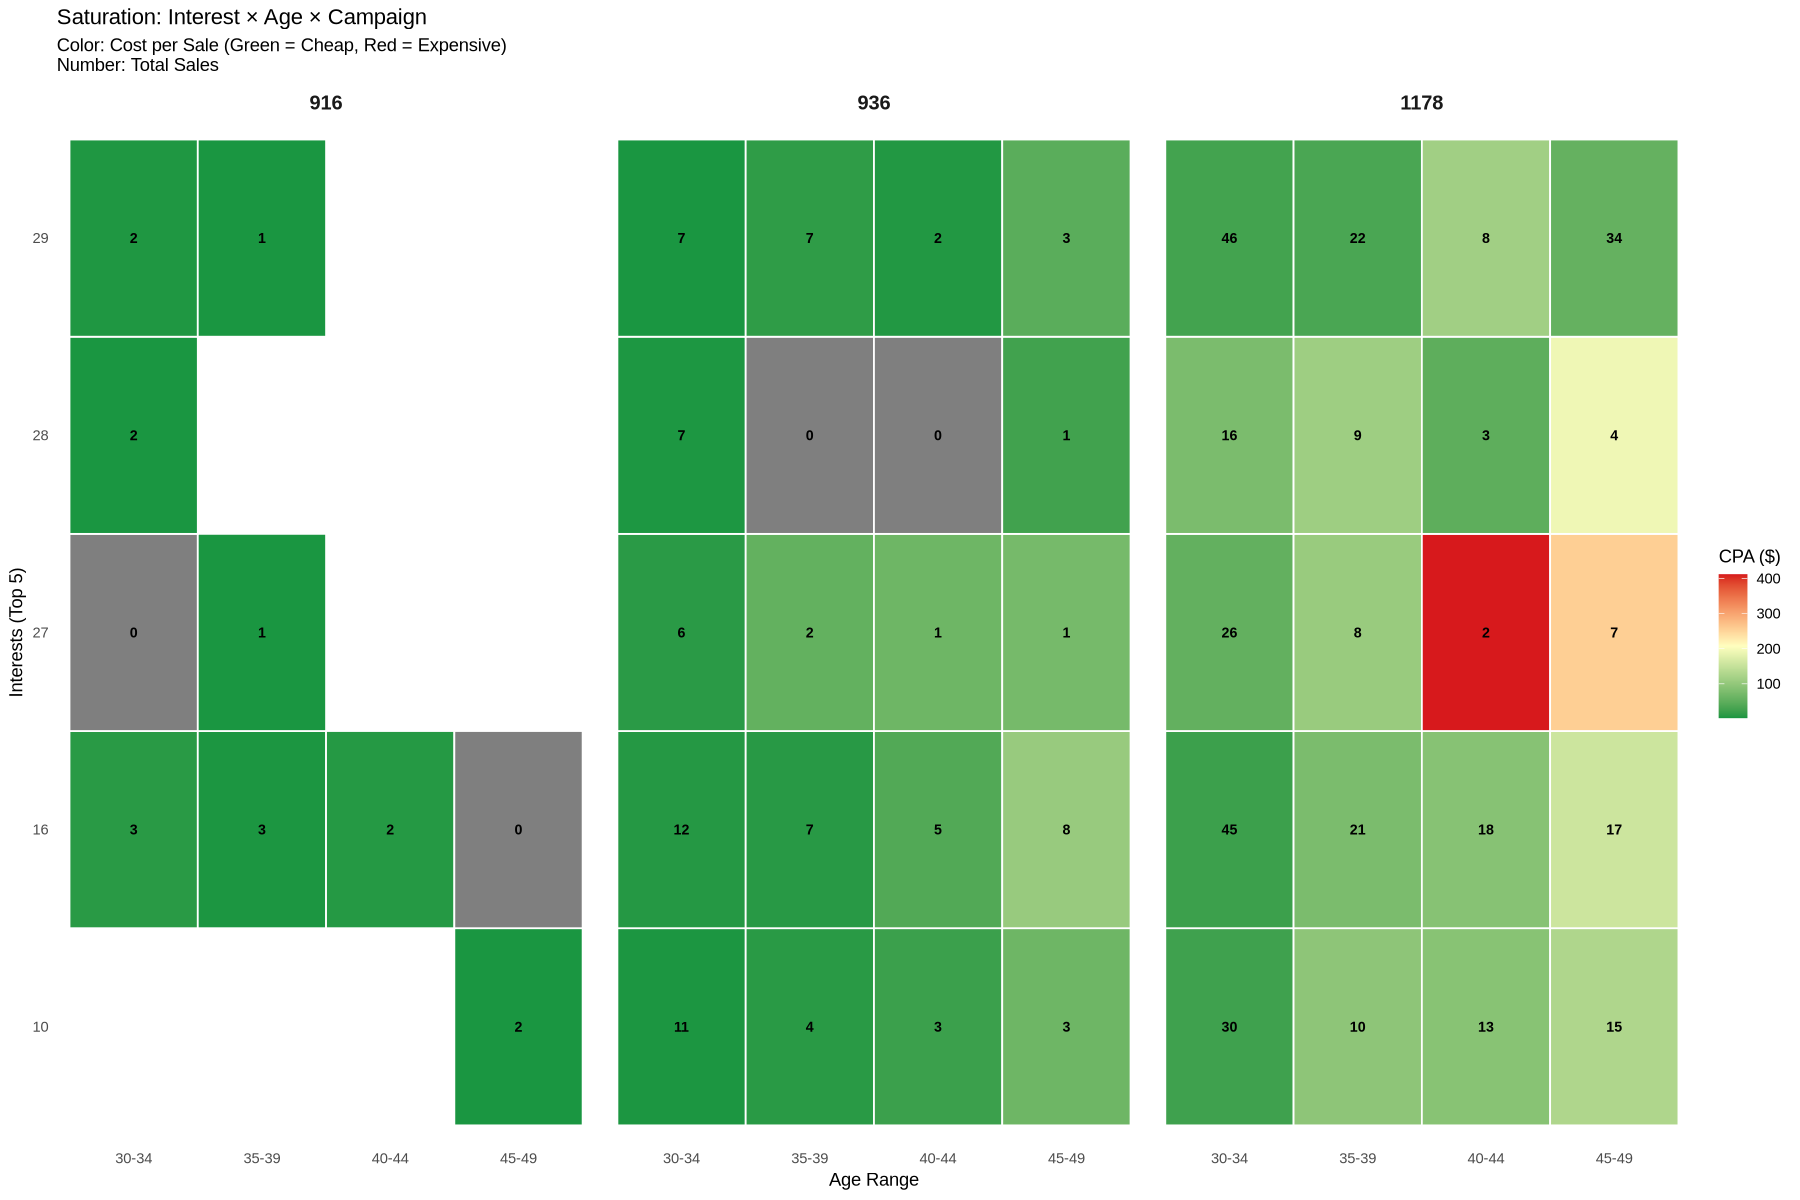

In [55]:
# Heatmap: Interest x age x campaign saturation
cpa_colors <- c("#1a9641", "#ffffbf", "#d7191c")

df %>%
  filter(interest %in% top_interest_codes) %>%
  group_by(xyz_campaign_id, interest, age) %>%
  summarise(
    cpa = sum(Spent) / sum(Approved_Conversion),
    sales = sum(Approved_Conversion),
    .groups = "drop"
  ) %>%
  ggplot(aes(x = age, y = as.factor(interest), fill = cpa)) +
  geom_tile(color = "white", size = 0.5) +
  geom_text(aes(label = sales), color = "black", size = 3, fontface = "bold") +
  facet_wrap(~ xyz_campaign_id) +
  scale_fill_gradientn(
    colors = cpa_colors,
    name = "CPA ($)"
  ) +
  labs(
    title = "Saturation: Interest × Age × Campaign",
    subtitle = "Color: Cost per Sale (Green = Cheap, Red = Expensive)\nNumber: Total Sales",
    y = "Interests (Top 5)",
    x = "Age Range"
  ) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    strip.text = element_text(face = "bold", size = 12)
  )


## Identified Pattern: 30-34 Range

The **30-34 years** range seems to perform consistently better across all campaigns, 
that is, it converts more with a lower CPA.

We need to drill down to the individual ad level. Certainly there are 
extremely expensive ads that don't generate returns and waste XYZ company resources.


## Ad Classification by Performance

I adopted the following classification for each ad using the **base average CPA (~$40)** 
and the number of conversions:

- **Zombie (Spends and doesn't sell)**: Didn't convert anyone and cost more than $50
- **Star (Cheap)**: CPA below base average
- **Expensive (Needs Optimization)**: CPA above base average
- **In Test**: Spending too low to classify

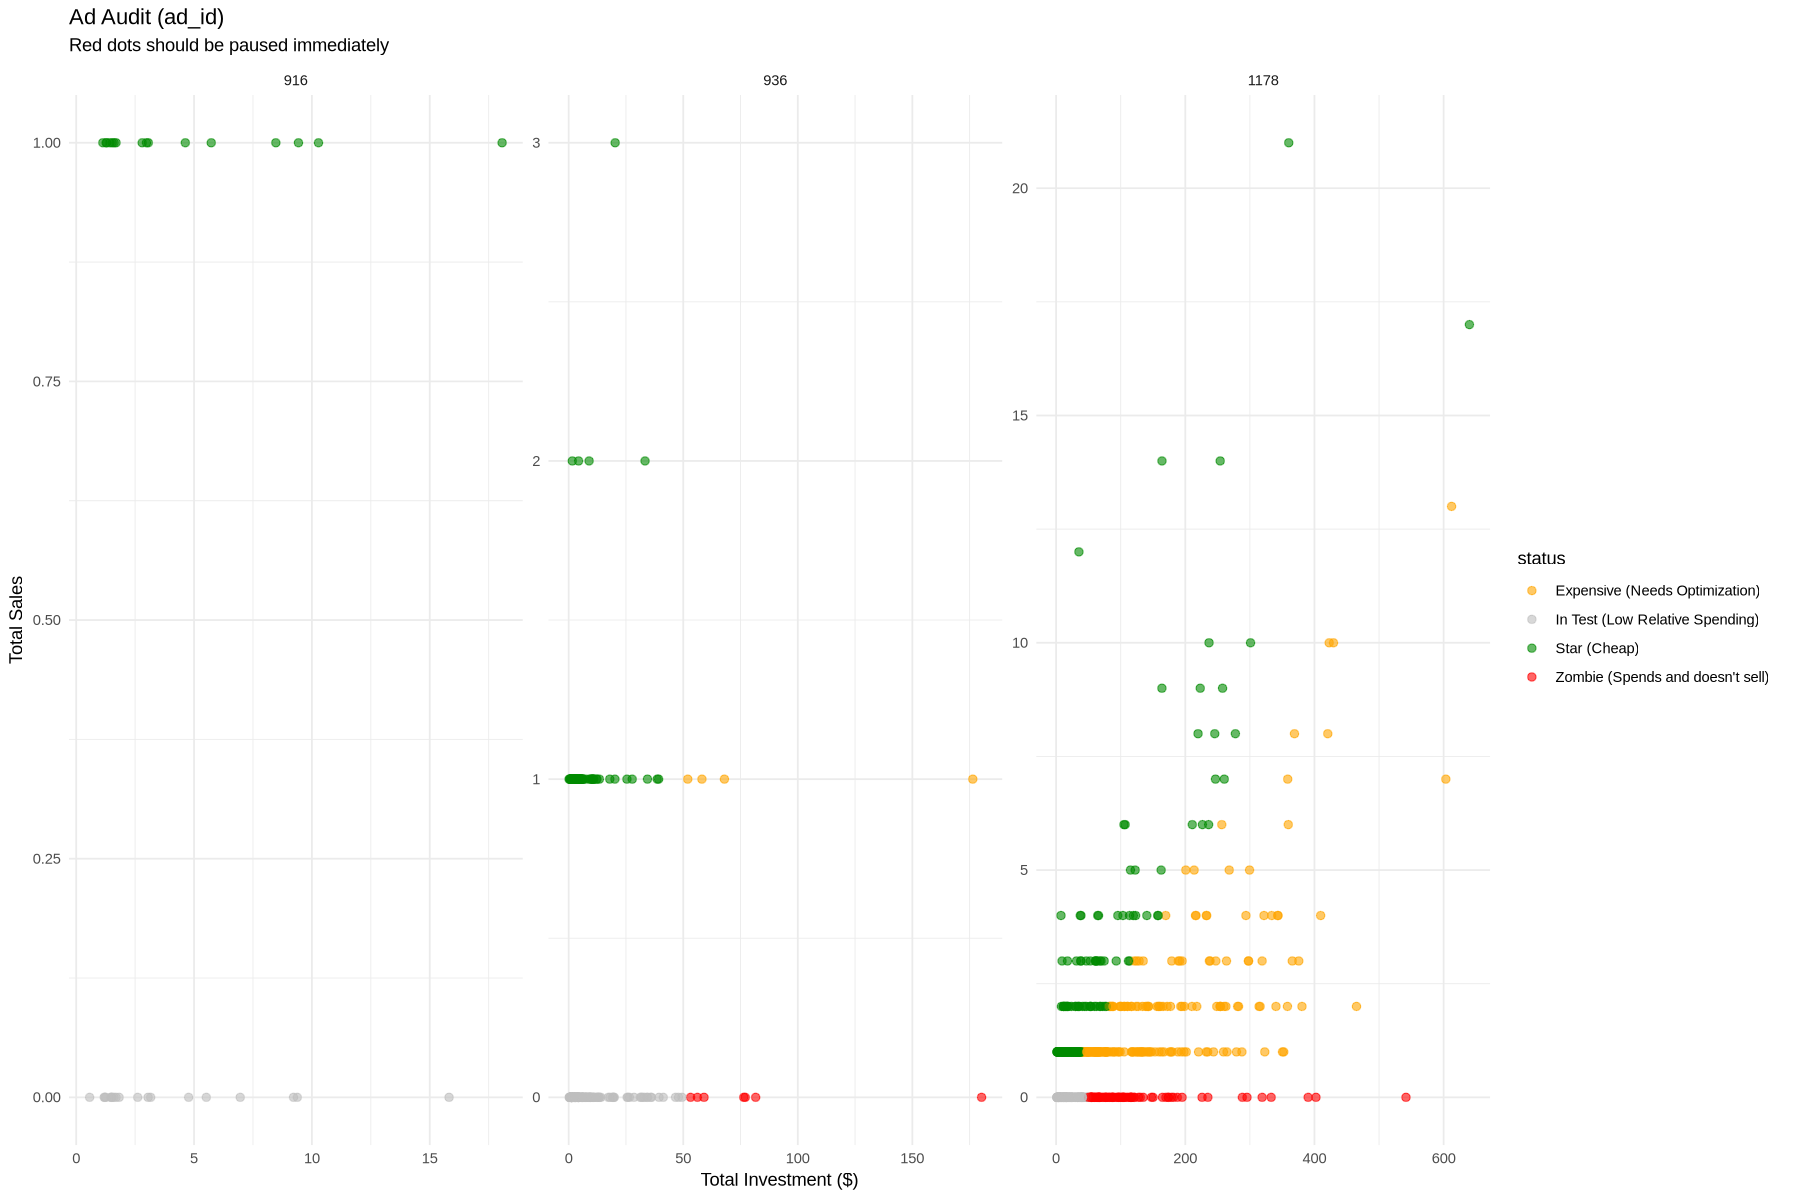

In [56]:
# Data aggregation by ad
df_ads <- df %>%
  group_by(ad_id, xyz_campaign_id) %>%
  summarise(
    spent = sum(Spent),
    impressions = sum(Impressions),
    clicks = sum(Clicks),
    sales = sum(Approved_Conversion),
    ctr = (sum(Clicks) / sum(Impressions)) * 100,
    cpa = ifelse(sales > 0, spent / sales, NA),
    .groups = "drop"
  )

# Ad classification
df_ads <- df_ads %>%
  mutate(
    status = case_when(
      (sales == 0 & (spent > 50 | is.na(spent))) ~ "Zombie (Spends and doesn't sell)",
      cpa < 40 ~ "Star (Cheap)",
      cpa >= 40 ~ "Expensive (Needs Optimization)",
      TRUE ~ "In Test (Low Relative Spending)"
    )
  )

# Visualization: Ad audit
df_ads %>%
  filter(spent > 0) %>%
  ggplot(aes(x = spent, y = sales, color = status)) +
  geom_point(alpha = 0.6, size = 2) +
  facet_wrap(~ xyz_campaign_id, scales = "free") +
  scale_color_manual(values = c(
    "Star (Cheap)" = "green4",
    "Expensive (Needs Optimization)" = "orange",
    "Zombie (Spends and doesn't sell)" = "red",
    "In Test (Low Relative Spending)" = "grey"
  )) +
  labs(
    title = "Ad Audit (ad_id)",
    subtitle = "Red dots should be paused immediately",
    x = "Total Investment ($)",
    y = "Total Sales"
  ) +
  theme_minimal()


## Alert: Zombie Ads

There are many ads to pause in **Campaign 1178** and several to optimize. 
**Campaign 936** also has a significant number of problematic ads.

Let's list the "zombie" ads with a recommendation to completely pause them, 
and segment the "star" ads to understand where we got it right.

In [57]:
# Counting zombie ads by campaign
df_ads %>%
  filter(status == "Zombie (Spends and doesn't sell)") %>%
  group_by(xyz_campaign_id) %>%
  summarise(
    qty_zombies = n(),
    total_spent = sum(spent)
  )

xyz_campaign_id,qty_zombies,total_spent
<dbl>,<int>,<dbl>
936,7,583.8
1178,80,9858.0



## Savings Opportunity

If XYZ company paused **today** all **87 zombie ads**, 
the immediate savings would be **$10,442**.

Let's examine the top 10 to identify the biggest wasters.

In [58]:
# Top 10 zombie ads by spending
df_ads %>%
  filter(status == "Zombie (Spends and doesn't sell)") %>%
  arrange(desc(spent)) %>%
  select(ad_id, xyz_campaign_id, spent, impressions, clicks) %>%
  head(10)

ad_id,xyz_campaign_id,spent,impressions,clicks
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1122265,1178,541.70,1428421,367
1122304,1178,402.30,1111156,282
1122112,1178,390.26,1083259,276
1122209,1178,332.99,890295,227
1314389,1178,319.00,1114711,224
1122202,1178,295.55,906151,202
1122127,1178,288.33,822023,194
1122197,1178,234.94,662249,163
1122203,1178,226.03,699314,164



## Waste Concentration

The **top 10** zombie ads represent just over **30% of total spending** 
wasted in this category.

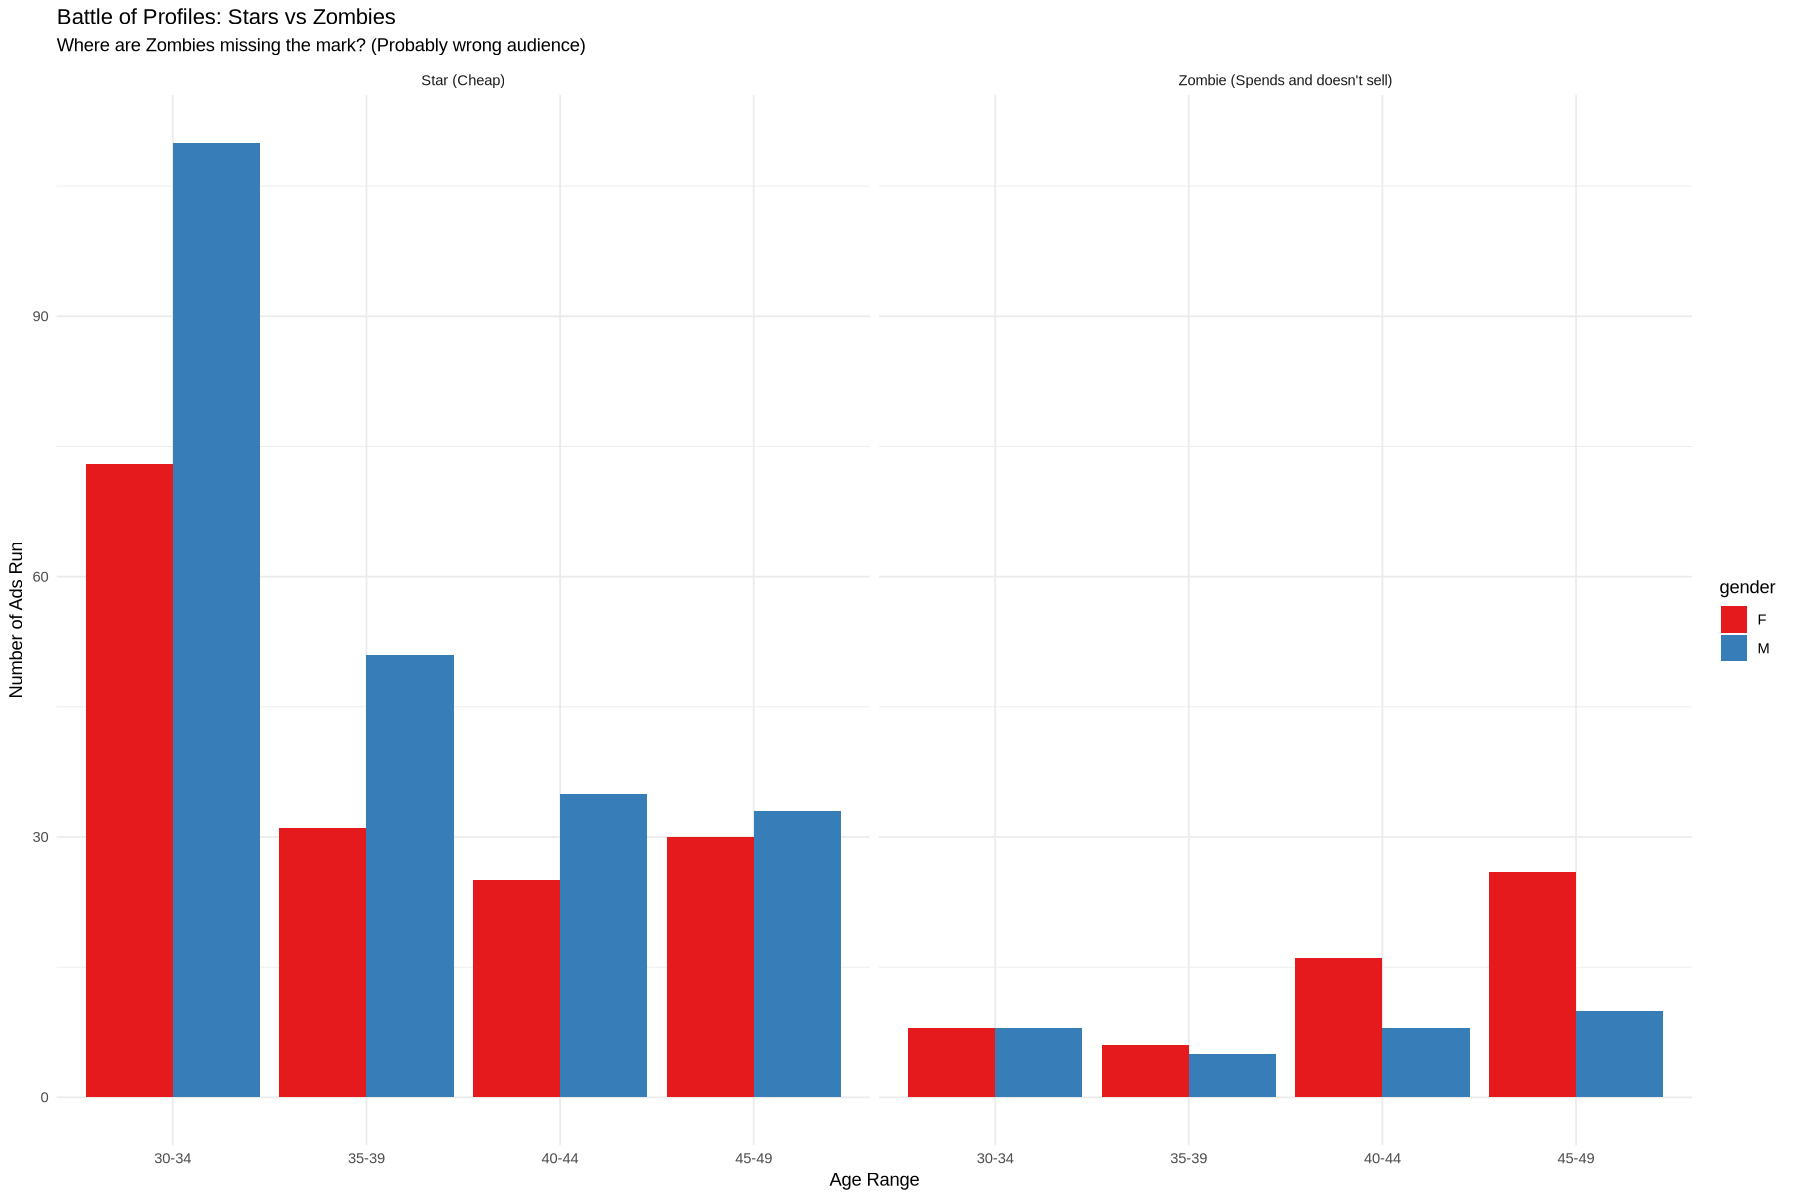

In [59]:
# Joining original data with status classification
df_classified <- df %>%
  inner_join(df_ads %>% select(ad_id, status, cpa), by = "ad_id")

# Comparison: Stars vs Zombies by demographic profile
df_classified %>%
  filter(status %in% c("Star (Cheap)", "Zombie (Spends and doesn't sell)")) %>%
  group_by(status, age, gender) %>%
  summarise(total = n(), .groups = "drop") %>%
  ggplot(aes(x = age, y = total, fill = gender)) +
  geom_col(position = "dodge") +
  facet_wrap(~ status) +
  scale_fill_brewer(palette = "Set1") +
  labs(
    title = "Battle of Profiles: Stars vs Zombies",
    subtitle = "Where are Zombies missing the mark? (Probably wrong audience)",
    y = "Number of Ads Run",
    x = "Age Range"
  ) +
  theme_minimal()


## Clear Demographic Pattern

An interesting trend emerges:

**Star Ads**:
- Focus more on **male** audience
- Target the **30-34 years** range (already identified earlier as promising)

**Zombie Ads**:
- Also emphasize male audience
- But focus on the **40-49 years** range

This suggests the problem is not gender, but rather the **poorly chosen age range**.

Let's now analyze how star and zombie clusters differ 
in **interest** segmentation.

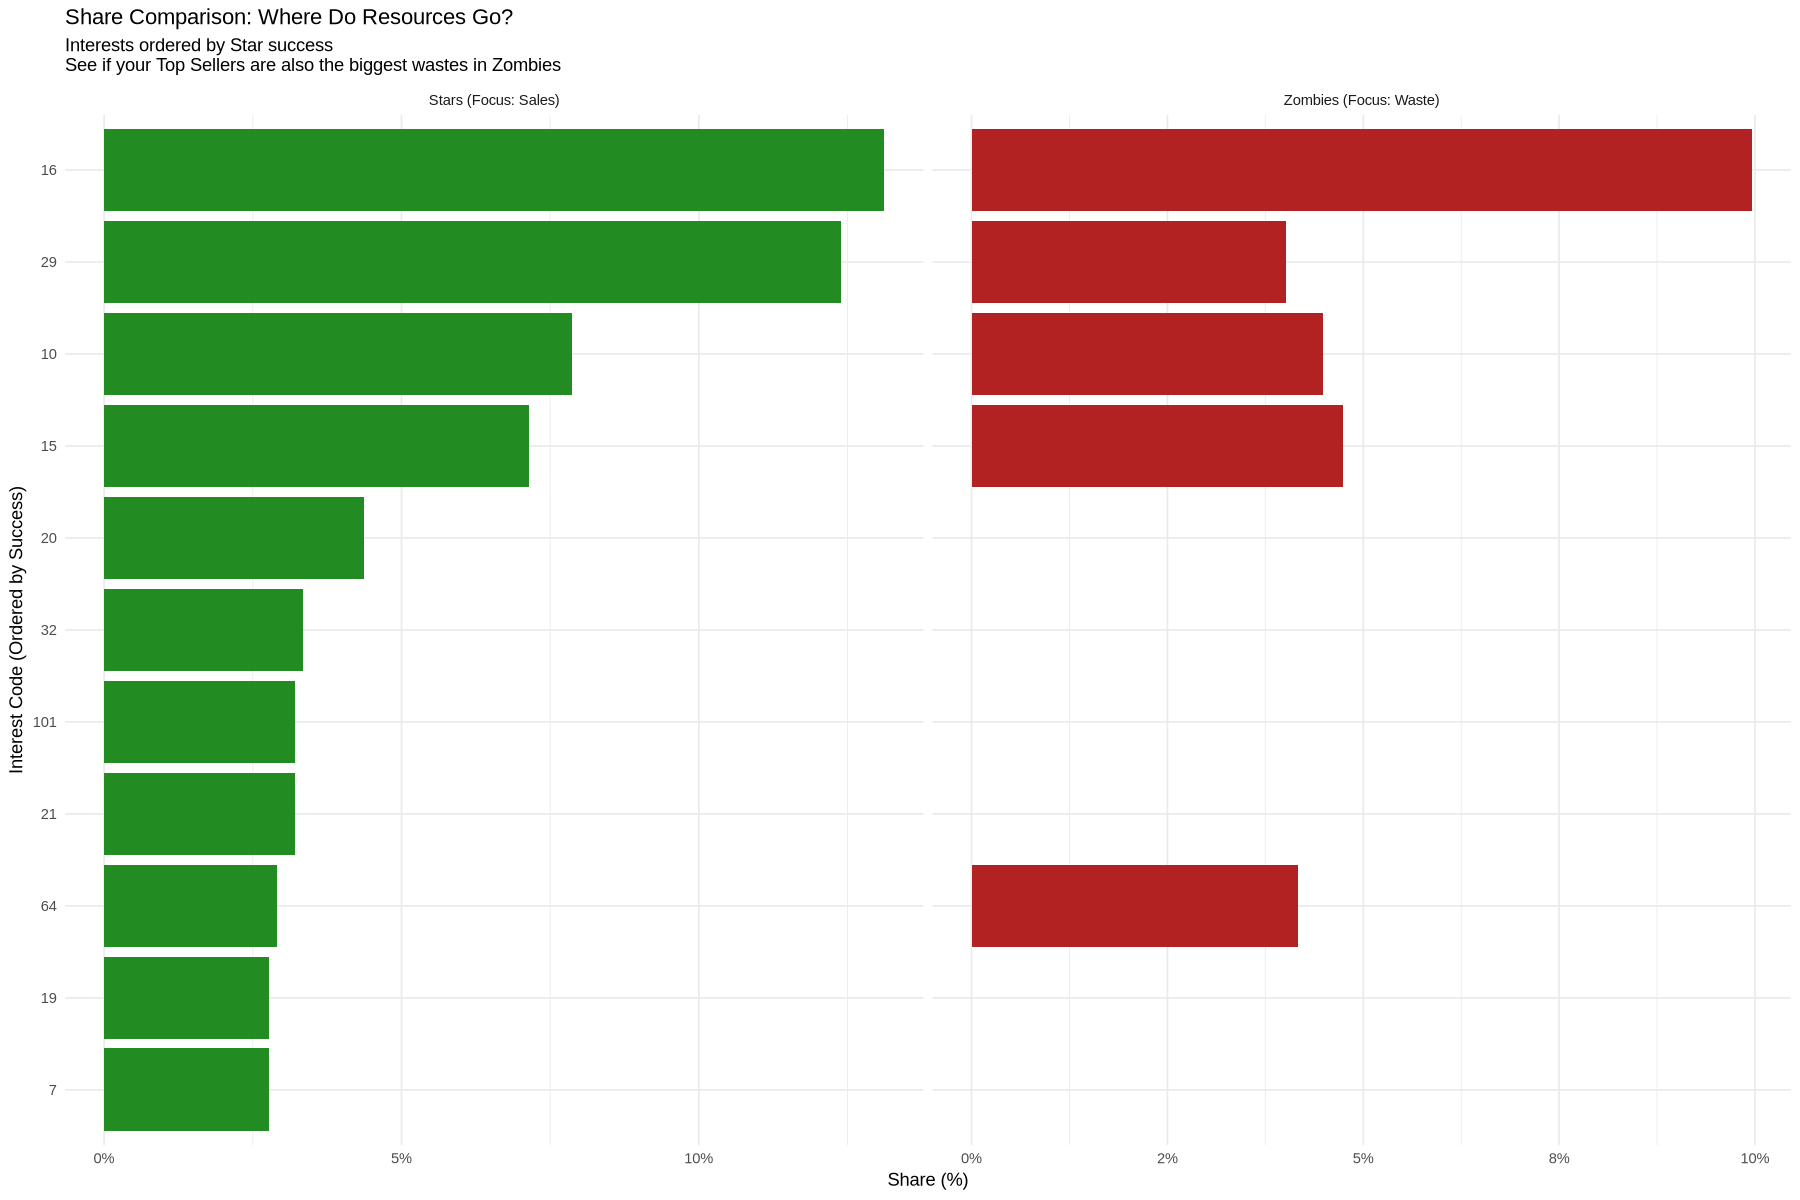

In [60]:

# Identification of top 10 interests in each cluster
top_interests_stars <- df_classified %>%
  filter(status == "Star (Cheap)") %>%
  group_by(interest) %>%
  summarise(value = sum(Approved_Conversion)) %>%
  mutate(
    type = "Stars (Focus: Sales)",
    share = value / sum(value)
  ) %>%
  slice_max(share, n = 10)

top_interests_zombies <- df_classified %>%
  filter(status == "Zombie (Spends and doesn't sell)") %>%
  group_by(interest) %>%
  summarise(value = sum(Spent)) %>%
  mutate(
    type = "Zombies (Focus: Waste)",
    share = value / sum(value)
  ) %>%
  slice_max(share, n = 10)

# Ordering based on star success
interest_order <- top_interests_stars %>%
  arrange(share) %>%
  pull(interest)

# Data preparation for visualization
plot_data <- bind_rows(top_interests_stars, top_interests_zombies) %>%
  mutate(interest = factor(interest, levels = interest_order)) %>%
  filter(!is.na(interest))

# Comparative visualization
ggplot(plot_data, aes(x = interest, y = share, fill = type)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~ type, scales = "free_x") +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  scale_fill_manual(values = c("forestgreen", "firebrick")) +
  labs(
    title = "Share Comparison: Where Do Resources Go?",
    subtitle = "Interests ordered by Star success\nSee if your Top Sellers are also the biggest wastes in Zombies",
    x = "Interest Code (Ordered by Success)",
    y = "Share (%)",
    fill = NULL
  ) +
  theme_minimal() +
  theme(legend.position = "none")


## Interest Overlap

It's notable that the **top 4 spending percentages are identical** between Stars and Zombies, 
but Zombie performance is absolutely worse.

This is mainly due to differences in **age segmentation** 
(40-49 years vs 30-34 years), not the interests themselves.

Let's identify **promising** interests that work well when properly segmented 
but fail when applied to the wrong audience.

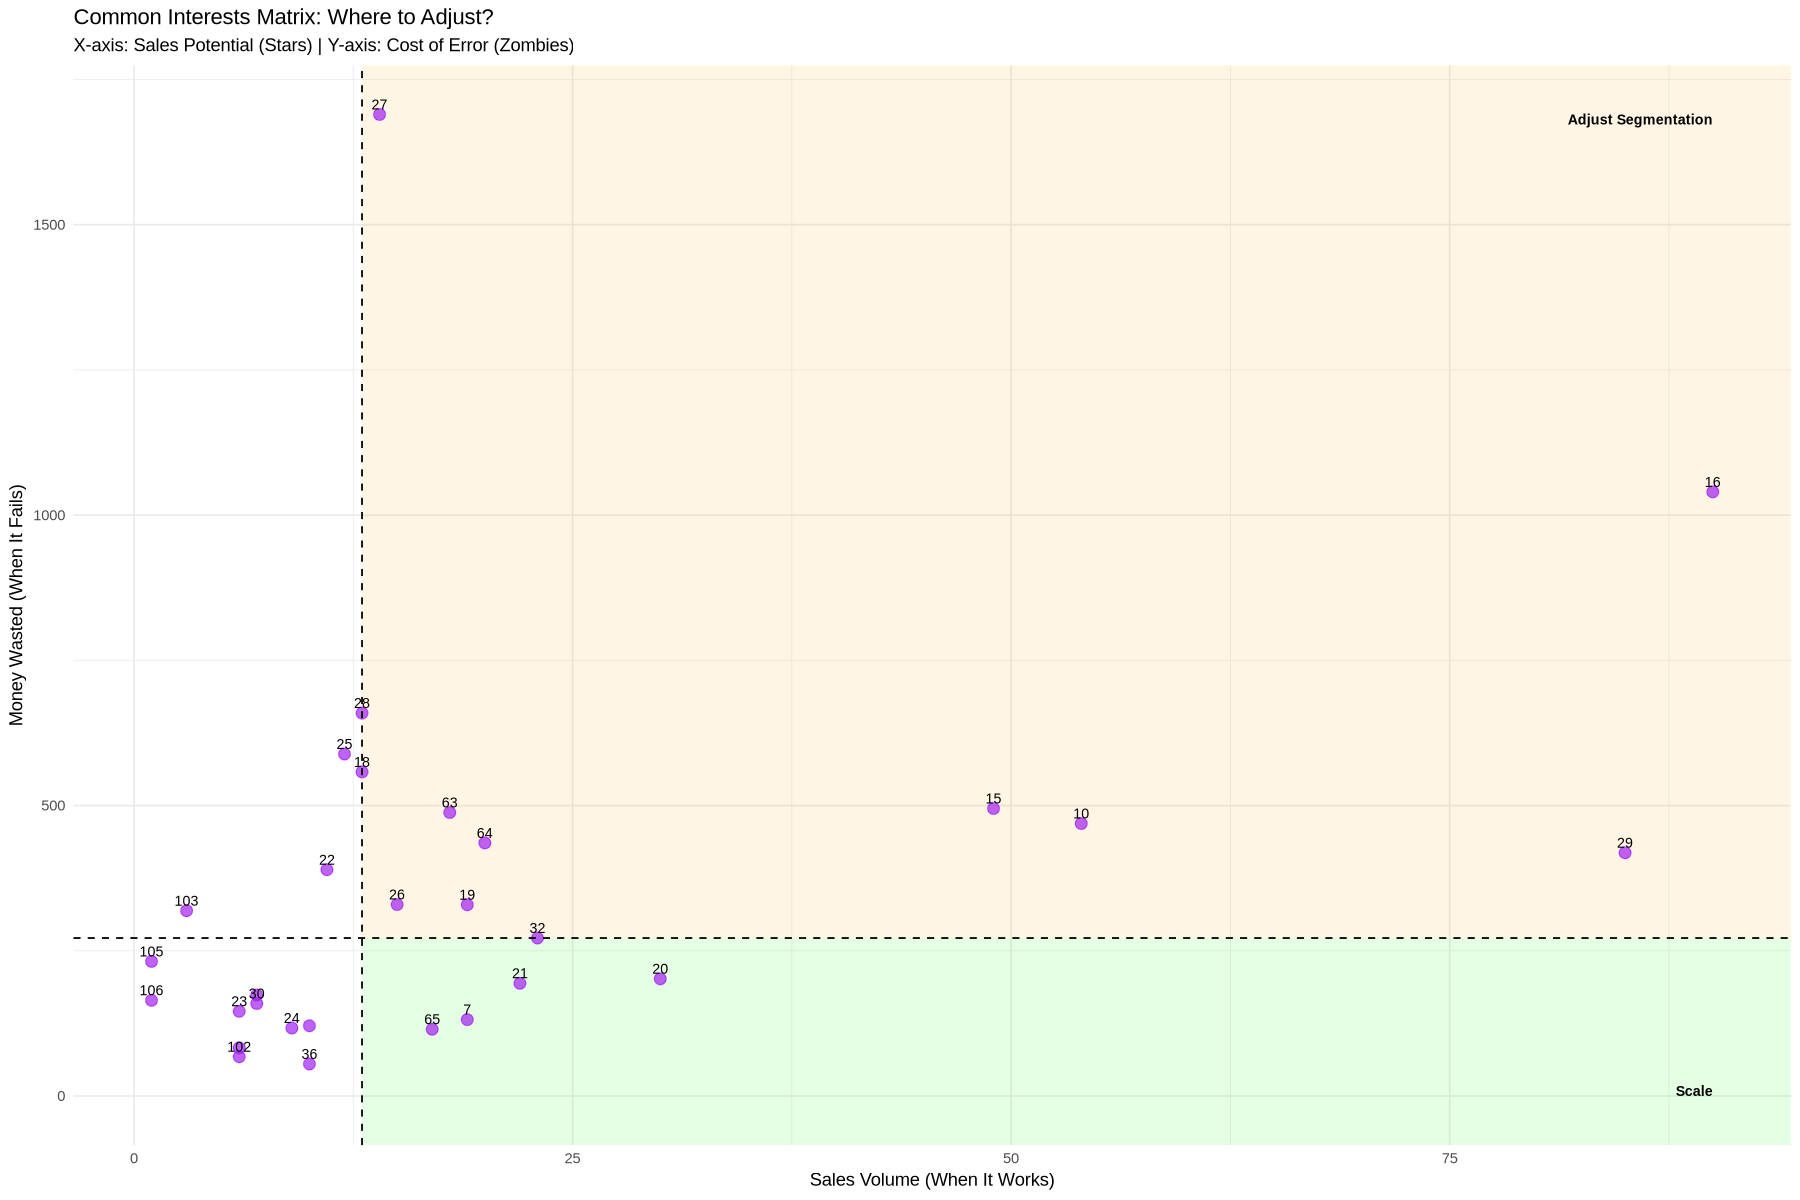

In [61]:
# Identification of common interests between stars and zombies
common_interests <- df_classified %>%
  group_by(interest) %>%
  summarise(
    star_sales = sum(Approved_Conversion[status == "Star (Cheap)"]),
    zombie_spent = sum(Spent[status == "Zombie (Spends and doesn't sell)"]),
    .groups = "drop"
  ) %>%
  filter(star_sales > 0, zombie_spent > 0)

# Median calculation for quadrants
median_sales <- median(common_interests$star_sales)
median_spent <- median(common_interests$zombie_spent)

# Visualization: Potential vs waste matrix
ggplot(common_interests, aes(x = star_sales, y = zombie_spent)) +
  annotate("rect", xmin = median_sales, xmax = Inf, ymin = median_spent, ymax = Inf, 
           fill = "orange", alpha = 0.1) +
  annotate("rect", xmin = median_sales, xmax = Inf, ymin = -Inf, ymax = median_spent, 
           fill = "green", alpha = 0.1) +
  geom_point(color = "purple", size = 3, alpha = 0.7) +
  geom_text(aes(label = interest), vjust = -0.5, size = 3, check_overlap = TRUE) +
  geom_vline(xintercept = median_sales, linetype = "dashed") +
  geom_hline(yintercept = median_spent, linetype = "dashed") +
  annotate("text", x = max(common_interests$star_sales), 
           y = max(common_interests$zombie_spent),
           label = "Adjust Segmentation", hjust = 1, vjust = 1, 
           fontface = "bold", size = 3) +
  annotate("text", x = max(common_interests$star_sales), y = 0,
           label = "Scale", hjust = 1, vjust = 0, fontface = "bold", size = 3) +
  labs(
    title = "Common Interests Matrix: Where to Adjust?",
    subtitle = "X-axis: Sales Potential (Stars) | Y-axis: Cost of Error (Zombies)",
    x = "Sales Volume (When It Works)",
    y = "Money Wasted (When It Fails)"
  ) +
  theme_minimal()


## Critical Insights: Inefficient Segmentation

It's evident that interests **29, 16, 10, 15, 19, 26, 64, 63, and 27** are 
globally promising, but end up failing in zombie ads due to 
**lack of efficient segmentation**.

In other words: it's not the interests that are wrong, 
but rather the **chosen target audience** (age and possibly gender).


## Statistical Validation: Difference by Age Range

Is the **30-34** age range **statistically different** from others 
regarding conversion?

In [62]:
# Data preparation for statistical test
age_data_general <- df %>%
  group_by(age) %>%
  summarise(
    sales = sum(Approved_Conversion),
    non_sales = sum(Clicks) - sum(Approved_Conversion),
    total_attempts = sum(Clicks)
  )

sales <- age_data_general$sales
attempts <- age_data_general$total_attempts

names(sales) <- age_data_general$age
names(attempts) <- age_data_general$total_attempts

# Pairwise proportion test with Bonferroni correction
age_test_corrected <- pairwise.prop.test(
  x = sales,
  n = attempts,
  p.adjust.method = "bonferroni"
)

print(age_test_corrected)


	Pairwise comparisons using Pairwise comparison of proportions 

data:  sales out of attempts 

      30-34   35-39   40-44 
35-39 3.3e-12 -       -     
40-44 < 2e-16 0.0378  -     
45-49 < 2e-16 2.9e-11 0.0014

P value adjustment method: bonferroni 



## Result: Statistical Difference Confirmed

The **30-34 years** range is **statistically different** from other age ranges 
in terms of conversion rate (p < 0.05 after Bonferroni correction).

This empirically validates our previous qualitative observation.


## Statistical Validation: Difference by Gender

Is there a significant difference in **CPA trend** between genders?

In [63]:
# Data preparation (only ads that converted)
cpa_gender_data <- df %>%
  filter(Approved_Conversion > 0) %>%
  mutate(cpa = Spent / Approved_Conversion)

# Kruskal-Wallis non-parametric test
kruskal.test(cpa ~ gender, data = cpa_gender_data)


	Kruskal-Wallis rank sum test

data:  cpa by gender
Kruskal-Wallis chi-squared = 11.7, df = 1, p-value = 0.0006251


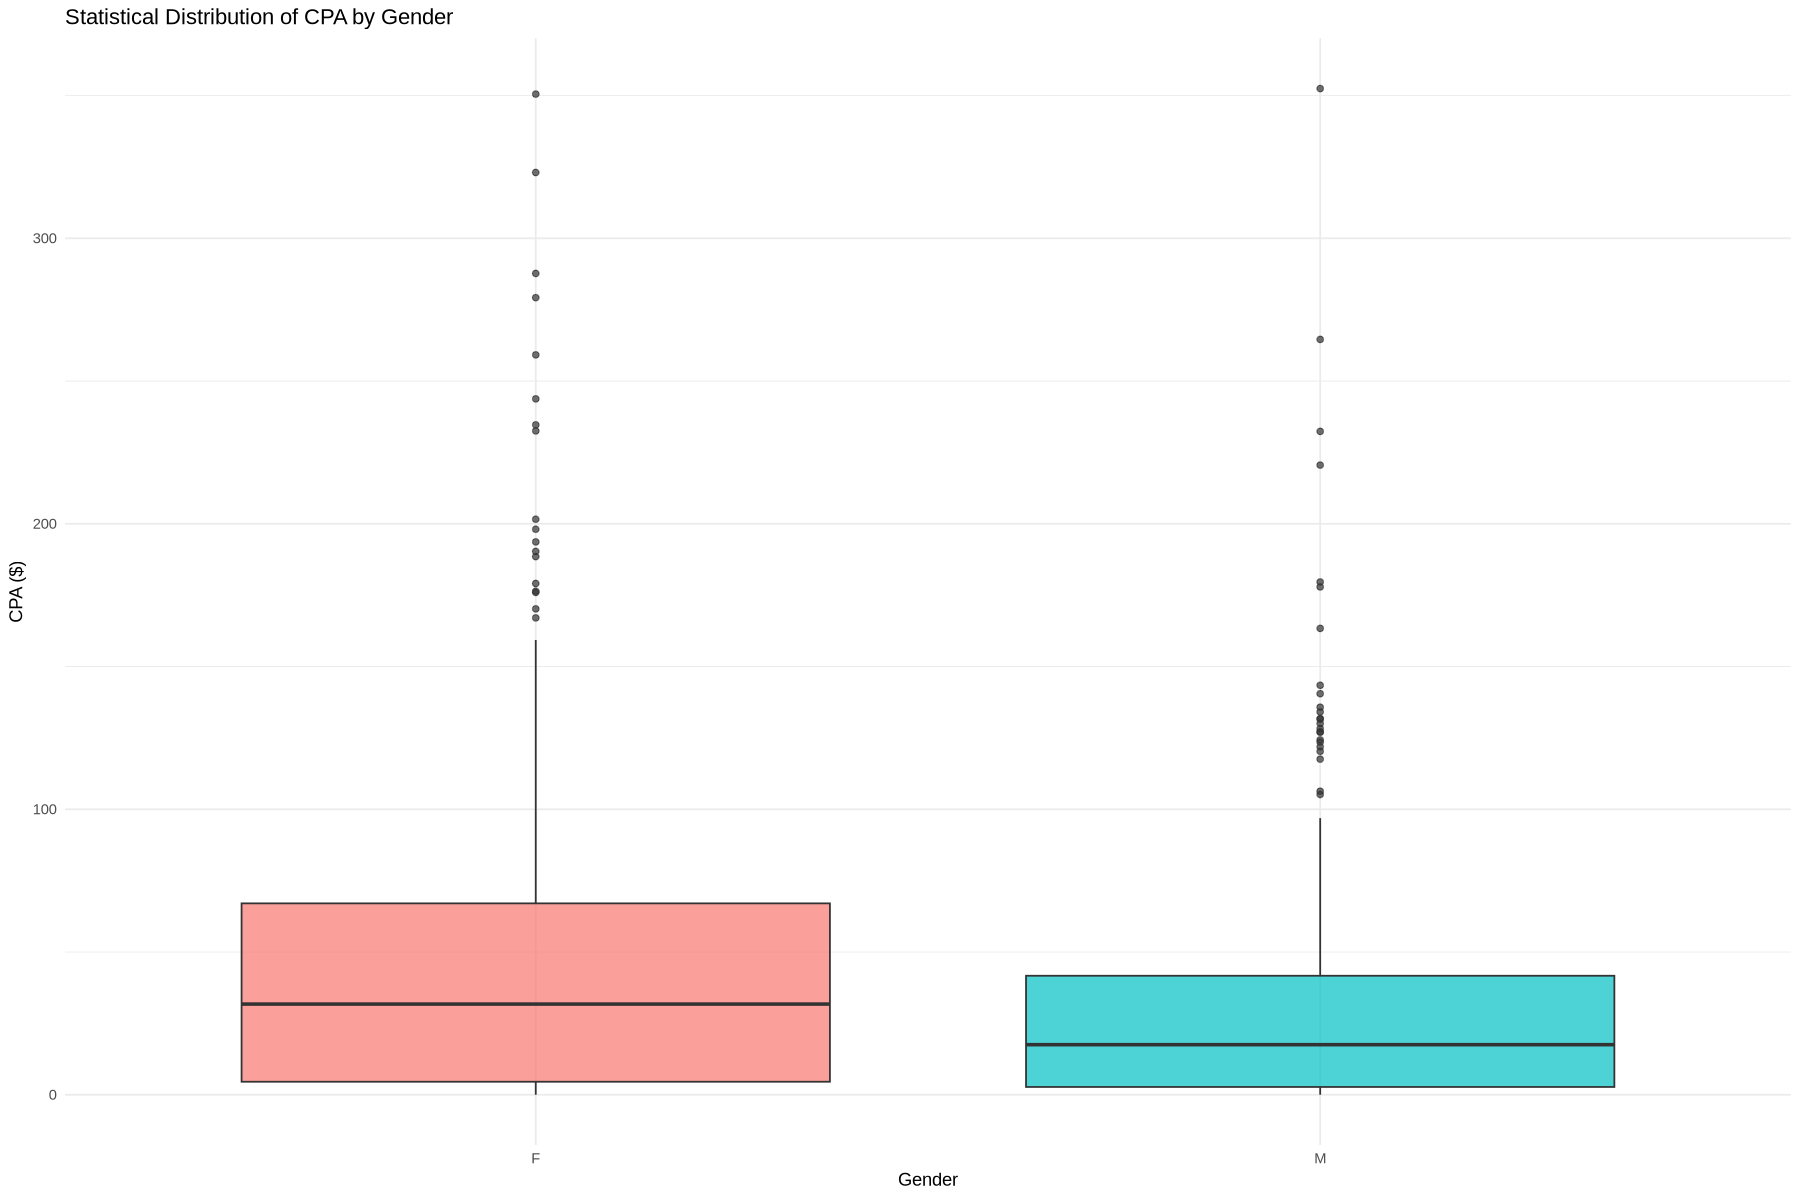

In [64]:
# Visualization of CPA distribution by gender
ggplot(cpa_gender_data, aes(x = gender, y = cpa)) +
  geom_boxplot(fill = c("#F8766D", "#00BFC4"), alpha = 0.7) +
  labs(
    title = "Statistical Distribution of CPA by Gender",
    x = "Gender",
    y = "CPA ($)"
  ) +
  theme_minimal()


## Result: Cost Difference by Gender

There is **statistical evidence** that one gender costs more than the other 
to convert (p < 0.05).

This should be considered in budget allocation decisions.


---

# Executive Report: Conclusions and Recommendations

## 1. Executive Summary

Data analysis identified that **Campaign 1178** shows a cost per sale 
drastically higher than previous campaigns. This cost increase is not due 
to the marketing channel itself, but to **inefficiency in audience segmentation** 
and **maintenance of ineffective ads**.

There is a clear opportunity to **reduce costs while maintaining sales volume** 
by concentrating the budget on proven buyer demographic profiles.

---

## 2. Problem Diagnosis

We identified three main factors draining the company's budget:

### 2.1. Demographic Dispersion
The campaign is spending significant budget on the **40 to 49 years** age range. 
Statistical tests confirm this group generates high viewing cost 
but **rarely converts to sales**.

### 2.2. Ads with Total Waste
We mapped a group of **87 ads** (identified as "Zombies") that consistently consume 
budget without having generated **any historical sales**. 
The accumulation of these expenses represents **$10,442** of total waste, 
with the top 10 accounting for 30% of this amount.

### 2.3. Inadequate Interest Segmentation
Several interests that **work well** for the younger audience (30-34 years) 
are being shown to the older audience, where they don't perform, 
generating a **false negative** about the quality of these interests.

---

## 3. High Performance Profile

Contrary to the dispersion observed in the current campaign, historical data 
shows a clear pattern of success. The ideal customer profile, which brings the 
**highest return on investment**, has the following characteristics:

### Ideal Target Audience Characteristics:
- **Age Range**: 30 to 34 years (statistically superior performance 
  to all other ranges, p < 0.05)
- **Behavior**: Specific interests (codes 29, 16, 10, 15, 19, 26, 64, 63, 27) 
  when targeted to this young audience convert at low cost
- **Gender Differentiation**: There is a statistically significant difference 
  in CPA between genders, which should be considered in allocation

---

## 4. Recommended Action Plan

### 4.1. Short-Term Actions (Immediate Implementation)

#### a) Pause Inefficient Ads
**Estimated savings: $10,442**
- Immediately stop running the **87 Zombie ads** listed 
  in the technical report
- Prioritize the top 10 that account for 30% of waste

#### b) Age Restriction
- Change **Campaign 1178** configuration to **exclude** ad display 
  for the **40 to 49 years** range
- This range showed high cost without proportional return

### 4.2. Medium-Term Actions (Strategic)

#### a) Budget Reallocation
- Direct the budget saved from the above actions to **intensify exposure** 
  in the **30 to 34 years** range, where the probability of sale is provenly higher

#### b) Focused Segmentation
- Create **new ad sets** using only the identified 
  high-performance interests (29, 16, 10, 15, 19, 26, 64, 63, 27)
- Restrict these ads **exclusively to the 30 to 34 years audience** 
  to avoid new waste
- Consider CPA difference by gender in proportional budget allocation

#### c) Continuous Testing and Learning
- Implement weekly monitoring of ads classified as "Expensive"
- Establish a **$50 test spending limit** before classifying 
  an ad as Zombie
- Create a quarterly review process to identify new promising interests

---

## 5. Expected Impact

With full implementation of recommendations, we estimate:

- **Immediate cost reduction**: ~$10,442 (Zombie pause)
- **CPA improvement**: 40-50% reduction by focusing on 30-34 audience
- **Maintenance or increase in sales volume**: Through intelligent budget reallocation
- **Improved ROI**: Concentration on provenly profitable segments